## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip \
    && unzip -o bank+marketing.zip && unzip -o bank.zip && rm *.zip


--2024-10-18 12:13:33--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [    <=>             ] 999.85K  1.05MB/s    in 0.9s    

2024-10-18 12:13:35 (1.05 MB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [3]:
df = pd.read_csv('bank-full.csv', sep=';')
X = df.drop(columns=['default', 'loan','y'])
y = (df['y']=='yes').astype(int)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `y` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [4]:
X_train_num = X_train.select_dtypes('number')
X_train_num.apply(lambda x:roc_auc_score(y_train, x) if roc_auc_score(y_train, x)>0.5 else roc_auc_score(y_train, -x)).sort_values()


age         0.512186
day         0.525958
campaign    0.571454
balance     0.588831
pdays       0.590128
previous    0.598565
duration    0.814700
dtype: float64

In [5]:
# pearsonr and auc give similar information on feature importance in this case
corr_auc = pd.concat((X_train_num.corrwith(y_train), \
            X_train_num.apply(lambda x:roc_auc_score(y_train, x))), axis=1)
corr_auc.rename(columns={0:'pearson_r',1:'auc'}).sort_values('auc')

,pearson_r,auc
campaign,-0.069854,0.428546
day,-0.028151,0.474042
age,0.016893,0.487814
balance,0.055903,0.588831
pdays,0.100222,0.590128
previous,0.102520,0.598565
duration,0.405950,0.814700


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [6]:
def logistic_reg(X_train, X_val, y_train, y_val, C=1.0):
    dv = DictVectorizer()
    X_train = dv.fit_transform(X_train.to_dict(orient='records'))
    X_val = dv.transform(X_val.to_dict(orient='records'))

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    y_val_score = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_val_score)
    return auc, y_val_score


auc, y_val_score = logistic_reg(X_train, X_val, y_train, y_val)
auc

0.9000611291793008

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [7]:
prf1 = []
for t in np.linspace(0,1,101):
    p = precision_score(y_val, y_val_score>=t, zero_division=np.nan)
    r = recall_score(y_val, y_val_score>=t)
    f1 = f1_score(y_val, y_val_score>=t)
    prf1.append((t,p,r,f1))

df_prf1 = pd.DataFrame(prf1, columns=['threshold','precision','recall','f1_score'])
pr_equal = df_prf1.query('precision.round(1)==recall.round(1)')
pr_equal

,threshold,precision,recall,f1_score
26,0.26,0.556250,0.567395,0.561767
27,0.27,0.563771,0.555556,0.559633


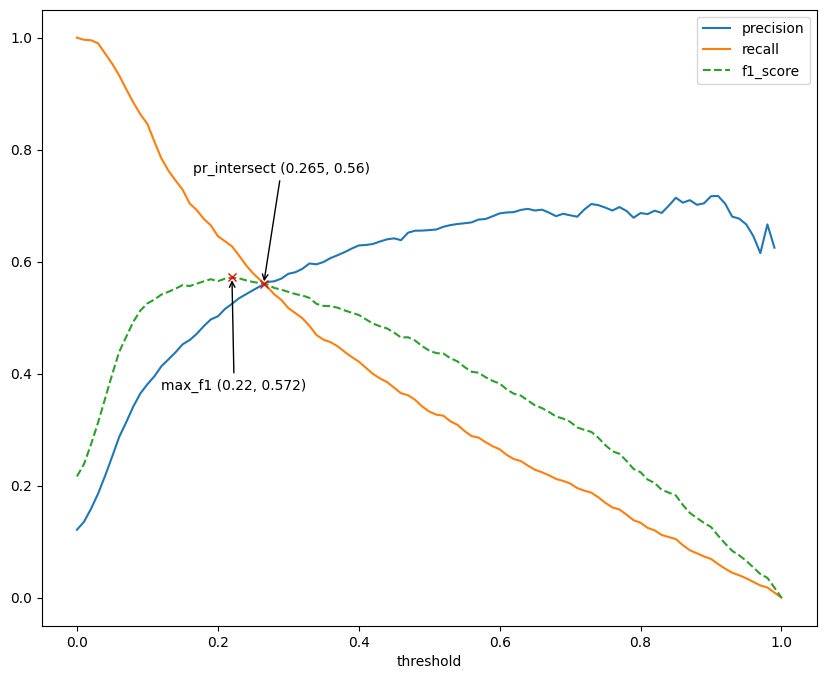

In [8]:
df_prf1.plot(x='threshold',y=['precision','recall','f1_score'], style=['-','-','--'], figsize=(10,8))
t_inter, prec = pr_equal[['threshold','precision']].mean().round(3)
t_f1, f1 = df_prf1.nlargest(1,'f1_score')[['threshold','f1_score']].round(3).squeeze()
plt.plot((t_inter,t_f1), (prec,f1), 'rx')
plt.annotate(f'pr_intersect {t_inter,prec}', (t_inter,prec), (t_inter-0.1,prec+0.2), arrowprops={'arrowstyle':'->'})
plt.annotate(f'max_f1 {t_f1,f1}', (t_f1,f1), (t_f1-0.1,f1-0.2), arrowprops={'arrowstyle':'->'})
plt.show()


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [9]:
def kfold_logistic_reg(X_train_val, y_train_val, n_splits=5, C=1.0):
    aucs = []
    kf = KFold(n_splits, shuffle=True, random_state=1)
    for train_idx, val_idx in kf.split(X_train_val):
        X_train = X_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_train = y_train_val.iloc[train_idx]
        y_val = y_train_val.iloc[val_idx]

        auc, _ = logistic_reg(X_train, X_val, y_train, y_val, C=C)    
        aucs.append(auc)         
    return aucs


aucs = kfold_logistic_reg(X_train_val, y_train_val)
aucs, np.mean(aucs), np.std(aucs)

([0.8993313721729044,
  0.8993379202316825,
  0.9112393179832716,
  0.9081164890704471,
  0.9119943189373679],
 0.9060038836791346,
 0.005598493850295184)

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [10]:
auc_stat = []
for C in [0.000001, 0.001, 1]:
    aucs = kfold_logistic_reg(X_train_val, y_train_val, C=C)
    auc_stat.append((C, np.round(aucs,4), np.mean(aucs), np.std(aucs)))

pd.DataFrame(auc_stat,columns=['C','auc','auc_mean','auc_std'])

,C,auc,auc_mean,auc_std
0,0.000001,"[0.6847, 0.7001, 0.712, 0.7087, 0.7016]",0.701445,0.009444
1,0.001000,"[0.8483, 0.8597, 0.8642, 0.8692, 0.8634]",0.860980,0.007012
2,1.000000,"[0.8993, 0.8993, 0.9112, 0.9081, 0.912]",0.906004,0.005598
